# Implementing Real Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.integrate as integrate
import scipy.special as special
from scipy.optimize import curve_fit
import math
import time
import pandas as pd
sns.set()
%matplotlib inline

In [2]:
## Generate current class ##

class current():
    
    # initialize current types and variables # 
    
    def __init__(self, height1=1, squeeze1=1, pos1=0, height2=1, squeeze2=1, pos2=0, shift=0, 
                 phi_t=8.01088e-19, phi_s=8.01088e-19, z = 0.5e-9, A=1e-9, 
                 erf=False, ohm=False, cubic=False, exp=False, double_erf=False, step=False, Simmons=False):
        self.height1 = height1
        self.squeeze1 = squeeze1
        self.pos1 = pos1
        self.height2 = height2
        self.squeeze2 = squeeze2
        self.pos2 = pos2
        self.shift = shift
        self.phi_t = phi_t
        self.phi_s = phi_s
        self.z = z
        self.A = A
        
        
        self.erf = erf
        self.ohm = ohm
        self.cubic = cubic
        self.exp = exp
        self.double_erf = double_erf
        self.step = step
        self.Simmons = Simmons
        
    # Call calculate to generate I[V(t)] #  
        
    def calculate(self, V):
        if self.erf == True:
            calculate = self.height1*special.erf((V-self.pos1)*self.squeeze1) + self.shift
        if self.double_erf == True:
            calculate = self.height1*special.erf((V-self.pos1)*self.squeeze1) + self.height2*special.erf((V - self.pos2)*self.squeeze2) + self.shift
        if self.cubic == True:
            calculate = self.height1*(V*self.squeeze1 - self.pos1)**3 + self.height2*(V*self.squeeze2 - self.pos2) + self.shift
        if self.step == True:
            calculate = self.height1 * (V > self.pos1)
        if self.ohm == True:
            calculate = (V - self.pos1)/self.height1 + self.shift
        if self.exp == True:
            calculate = self.height1*np.exp(-(V*self.squeeze1 - self.pos1)) + self.shift
        if self.Simmons == True:

            I = []
            
            for i in range(0,len(V)):
                

                if V[i]*1.60217662e-19 > -self.phi_t and V[i]*1.60217662e-19 < self.phi_s:
                    phi_bar = (self.phi_t+self.phi_s-abs(V[i])*1.60217662e-19)/2
                    delta = self.z
                   

                if V[i]*1.60217662e-19 >= self.phi_s:
                    phi_bar = self.phi_t/2
                    delta = self.z*self.phi_t/(self.phi_t-self.phi_s+abs(V[i])*1.60217662e-19)
                    beta = 23/24
                

                if V[i]*1.60217662e-19 <= -self.phi_t:
                    phi_bar = self.phi_s/2
                    delta = self.z*self.phi_s/(self.phi_s-self.phi_t+abs(V[i])*1.60217662e-19)
                    beta = 23/24
                   

                if V[i]*1.60217662e-19 >= 0 and V[i]*1.60217662e-19 < self.phi_s:
                    beta = 1-1/24*((abs(V[i])*1.60217662e-19-self.phi_s+self.phi_t)/(abs(V[i])*1.60217662e-19-self.phi_s-self.phi_t))**2
                
                if V[i]*1.60217662e-19 > -self.phi_t and V[i]*1.60217662e-19 < 0:
                    beta = 1-1/24*((abs(V[i])*1.60217662e-19+self.phi_s-self.phi_t)/(abs(V[i])*1.60217662e-19-self.phi_s-self.phi_t))**2
                  

                if V[i] >= 0:
                    I.append(1.60217662e-19*self.A/(1.0545718e-34*(2*np.pi*beta*delta)**2)*(
                        phi_bar*np.exp(-2*beta*delta*np.sqrt(9.10938356e-31*2*phi_bar)/1.0545718e-34)
                        -(phi_bar+abs(V[i])*1.60217662e-19)*np.exp(-2*beta*delta*np.sqrt(9.10938356e-31*2)
                                                           *np.sqrt(phi_bar+abs(V[i])*1.60217662e-19)/1.0545718e-34)))
               
             

                if V[i] < 0: 
                    I.append(-1.60217662e-19*self.A/(1.0545718e-34*(2*np.pi*beta*delta)**2)*(
                        phi_bar*np.exp(-2*beta*delta*np.sqrt(9.10938356e-31*2*phi_bar)/1.0545718e-34)
                        -(phi_bar+abs(V[i])*1.60217662e-19)*np.exp(-2*beta*delta*np.sqrt(9.10938356e-31*2)
                                                           *np.sqrt(phi_bar+abs(V[i])*1.60217662e-19)/1.0545718e-34)))
                
            
            calculate = np.asarray(I)

           
    
        else:
            pass
        
        return calculate

In [3]:
## Function that creates nth order polynomial for fit ##

def arb_odd_poly(x, *params):
    return sum([p*(x**(2*i+3)) for i, p in enumerate(params)])

def arb_even_poly(x, *params):
    return sum([p*(x**(2*i+2)) for i, p in enumerate(params)])

In [4]:
def rectify(V, pos_E0, neg_E0, t, Q_pos, Q_neg, fit_terms):
    
    """The rectify function takes in experimental values for the input waveform, amplitudes
       (waveform maximums and minimums from positive and negative sweeps respectively), and the 
       results from the Q[V(phi=0)] and Q[V(phi=pi)] sweeps. It fits a polynomial of order 2 
       and above to any data and reconstructs an I-V curve.
       
       ***PARAMETERS***
       
       V: Waveform.
       pos_E0: Waveform maximums from sweep using V(phi=0).
       neg_E0: Waveform minimums from sweep using V(phi=pi).
       t: Waveform time domain.
       Q_pos: Q[V(phi=0)] sweep data. Positive cosine wave as a function of waveform maximums.
       Q_neg: Q[V(phi=pi)] sweep data. Negative cosine wave as a function of waveform maximums.
       
       """
    
    a_n = []                
    rec_current = [] 
    I_t = []

    even_order = (Q_pos+Q_neg)/2
    odd_order = (Q_pos-Q_neg)/2
    
    popt1, pcov1 = curve_fit(f = arb_even_poly, xdata=pos_E0 ,   # fit the even ordered data
                       ydata = np.real(even_order), p0=[1]*(fit_terms)) # default initial guess to be 1


    popt2, pcov2 = curve_fit(f = arb_odd_poly, xdata=pos_E0 ,   # fit the odd ordered data
                       ydata = np.real(odd_order), p0=[1]*(fit_terms))  # default initial guess to be 1


    for i in range(0,len(popt1)):
        a_n.append(popt1[i]/integrate.simps(V**(2*i+2),x=t)) 
        a_n.append(popt2[i]/integrate.simps(V**(2*i+3),x=t))

    a_n = np.asarray(a_n)    
    E0 = np.concatenate((neg_E0,pos_E0), axis=0)
    
    for i in range(0,len(a_n)):
        rec_current.append(a_n[i]*E0**(i+2))  # reconstruct current
        I_t.append(a_n[i]*V**(i+2))
 
    rec_I = np.sum(rec_current, axis = 0)
    I_t = np.sum(I_t, axis = 0)
    
    return np.array([rec_I, I_t, a_n])

## Using real waveform to find I-V

In [5]:
file = 'sample_data/Symmetric_waveform_short_scan_window.txt'
short_sym = pd.read_csv(file, delimiter = '\t') # import data set
short_sym.drop(short_sym.index[[0]]) # dropping extra row
short_sym.head() # print first five data points

,Time,Electric field
0,-5.00,-0.000571
1,-4.98,-0.000756
2,-4.96,-0.001311
3,-4.94,-0.002237
4,-4.92,-0.002052


In [6]:
time = short_sym['Time'].values # make columns matrix
efield = short_sym["Electric field"].values

Text(0.5, 0, 'Time')

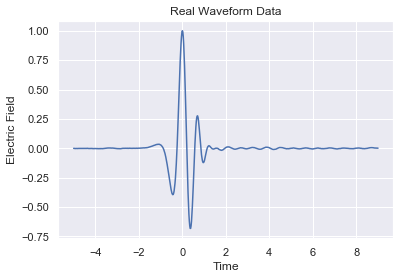

In [7]:
plt.plot(time, efield)
plt.title("Real Waveform Data")
plt.ylabel("Electric Field")
plt.xlabel("Time")

In [8]:
## Check to see if the integral = 0 ##

integral = integrate.simps(x=time, y=efield)
print(integral)

0.014933940605214274


In [9]:
## Generating Q(V) data ##

I = current(Simmons = True)
pos_E0 = np.linspace(0,8,2002)
neg_E0 = np.linspace(-8,0,2002)
E0 = np.concatenate((neg_E0,pos_E0),axis=0)
t=np.linspace(-4,4,2002) # try to keep consistent with rest of notebook
sweep_pts = 2002

pos_sweep = []
neg_sweep = []

for i in range(0,sweep_pts):
    pos_sweep.append(integrate.simps(x=time, y=I.calculate(V=pos_E0[i]*efield))) # probe positive portion of I-V
    neg_sweep.append(integrate.simps(x=time, y=I.calculate(V=-pos_E0[i]*efield))) # probe negative portion

pos_sweep = np.asarray(pos_sweep)
neg_sweep = np.asarray(neg_sweep)

In [10]:
rec_I = rectify(V=efield, pos_E0=pos_E0, neg_E0=neg_E0, t=time, Q_pos=pos_sweep, Q_neg=neg_sweep, fit_terms = 12)

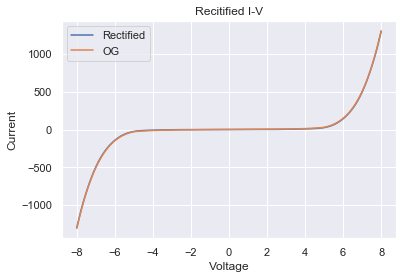

In [11]:
plt.plot(E0, rec_I[0], label = 'Rectified')
plt.plot(E0, I.calculate(E0), label = 'OG')
plt.title('Recitified I-V')
plt.xlabel("Voltage")
plt.ylabel("Current")
plt.legend()

## Test Real Q(V) Data

In [13]:
file = 'sample_data/THz_waveform.txt'
waveform = pd.read_csv(file, delimiter = '\t')
time = waveform['-3.6025'].values
THz = waveform['-0.00369'].values
waveform.head()


,-3.6025,-0.00369
0,-3.55247,-0.002580
1,-3.50244,-0.000909
2,-3.45238,-0.002580
3,-3.40235,-0.003690
4,-3.35231,-0.003690


In [25]:
file = 'figures/THz-IE Fig 3e Nature Physics.txt'
I_E = pd.read_csv(file, delimiter = '\t') # import data set
I_eField = I_E['I_THz'].values
I_eCharge = I_E['E_THz,pk'].values
I_E.head()

,I_THz,"E_THz,pk"
0,-259.71303,-35.78321
1,-248.56799,-29.05402
2,-238.94951,-24.68993
3,-229.95019,-21.28921
4,-217.17182,-18.01873


In [26]:
file = 'figures/IV for THz-IE Fig 3e Nature Physics.txt'
I_V = pd.read_csv(file, delimiter = '\t')
I_V = I_V.drop(columns=['Unnamed: 2'])
I_vVolt = I_V['V'].values
I_vCurrent = I_V['Current'].values
I_V.head()

,V,Current
0,-5.00,-0.00121
1,-4.99,-0.00120
2,-4.98,-0.00119
3,-4.97,-0.00118
4,-4.96,-0.00117


In [27]:
def arb_poly(x, *params):
    return sum([p*(x**(i+2)) for i, p in enumerate(params)])

In [28]:
def rectify(V, E0, t, Q, fit_terms):
    
    """The rectify function takes in experimental values for the input waveform, amplitudes
       (waveform maximums and minimums from positive and negative sweeps respectively), and the 
       results from the Q[V(phi=0)] and Q[V(phi=pi)] sweeps. It fits a polynomial of order 2 
       and above to any data and reconstructs an I-V curve.
       
       ***PARAMETERS***
       
       V: Waveform.
       pos_E0: Waveform maximums from sweep using V(phi=0).
       neg_E0: Waveform minimums from sweep using V(phi=pi).
       t: Waveform time domain.
       Q_pos: Q[V(phi=0)] sweep data. Positive cosine wave as a function of waveform maximums.
       Q_neg: Q[V(phi=pi)] sweep data. Negative cosine wave as a function of waveform maximums.
       
       """
    
    a_n = []                
    rec_current = [] 
    I_t = []

#     even_order = (Q_pos+Q_neg)/2
#     odd_order = (Q_pos-Q_neg)/2
    
    popt1, pcov1 = curve_fit(f = arb_poly, xdata=E0 ,   # fit the even ordered data
                       ydata = np.real(Q), p0=[1]*(fit_terms)) # default initial guess to be 1


#     popt2, pcov2 = curve_fit(f = arb_odd_poly, xdata=pos_E0 ,   # fit the odd ordered data
#                        ydata = np.real(odd_order), p0=[1]*(fit_terms))  # default initial guess to be 1


    for i in range(0,len(popt1)):
        a_n.append(popt1[i]/integrate.simps(V**(i+2),x=t)) 

    a_n = np.asarray(a_n)    

    
    for i in range(0,len(a_n)):
        rec_current.append(a_n[i]*E0**(i+2))  # reconstruct current
        I_t.append(a_n[i]*V**(i+2))
 
    rec_I = np.sum(rec_current, axis = 0)
    I_t = np.sum(I_t, axis = 0)
    
    return np.array([rec_I, I_t, a_n])

In [29]:
def Q_data(t, I, V, E0):
    
    """The Q_data function simulates rectified charge as a function of driving amplitudes
       for the V(phi=0) and V(phi=pi) cases. Use this function to compare to theoretical
       values.
       
       ***PARAMETERS***
       
       t: Time domain.
       I: Current type. Must be an activated class.
       V: Waveform.
       E0: List of driving amplitudes. Must go from 0 to E0max (i.e. [0,E0]).
       """
    
    sweep = []


    for i in range(0,len(E0)):
        sweep.append(integrate.simps(x=t, y=I.calculate(V=E0[i]*V))) # probe positive portion of I-V
       # neg_sweep.append(integrate.simps(x=t, y=I.calculate(V=-E0[i]*V))) # probe negative portion

    sweep = np.asarray(sweep)
   
    return sweep





In [30]:
real_IV = rectify(V=THz, E0 = I_eField, t=time, Q=I_eCharge, fit_terms=10)

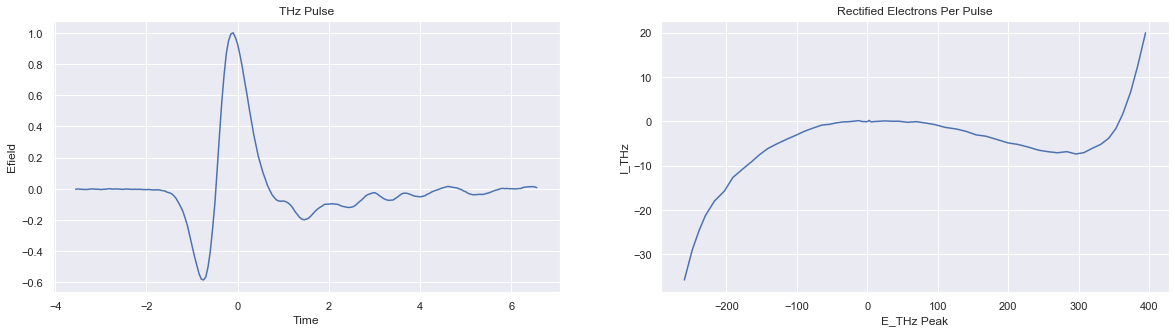

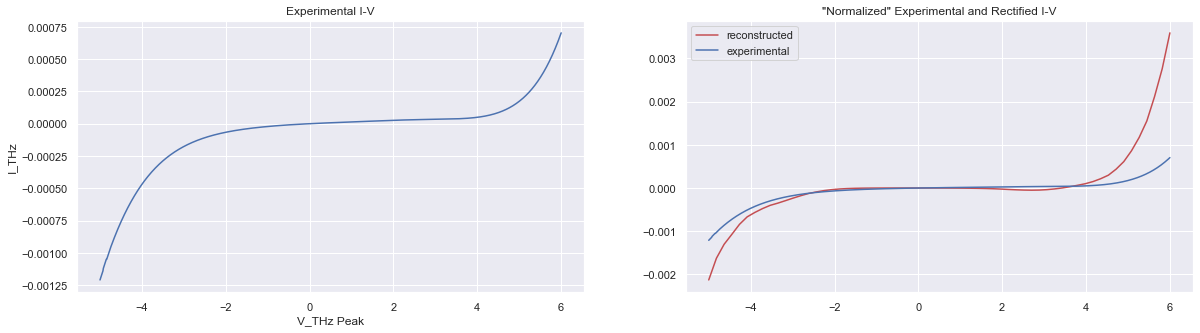

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))
fig, (ax3, ax4) = plt.subplots(1,2, figsize = (20,5))

ax1.plot(time,THz)
ax1.set_title("THz Pulse")
ax1.set_xlabel("Time")
ax1.set_ylabel("Efield")

ax2.plot(I_eField,I_eCharge)
ax2.set_xlabel('E_THz Peak')
ax2.set_ylabel('I_THz')
ax2.set_title('Rectified Electrons Per Pulse')

ax3.plot(I_vVolt,I_vCurrent)
ax3.set_xlabel("V_THz Peak")
ax3.set_ylabel("I_THz")
ax3.set_title('Experimental I-V')

E0 = np.linspace(-5,6, len(real_IV[0]))
ax4.plot(E0, real_IV[0]/0.5e5,'r', label= 'reconstructed')
ax4.plot(I_vVolt,I_vCurrent, label = 'experimental')
# ax4.plot(E0[:-1], np.diff(real_IV[0]/max(real_IV[0]))/np.diff(E0),'r', label= 'reconstructed')
# ax4.plot(I_vVolt[:-1],np.diff(I_vCurrent/max(I_vCurrent))/np.diff(I_vVolt), label = 'experimental')


ax4.set_title('"Normalized" Experimental and Rectified I-V')
ax4.legend()